In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # Nueva importación necesaria

In [2]:
# 1. CARGA DE DATOS
archivo = 'db\Iniciativas_VcM_2025_03_12_2025_12_47.xlsx'
df_raw = pd.read_excel(archivo, skiprows=2)
df_raw.columns = df_raw.columns.str.strip()

# 2. LIMPIEZA
df = df_raw.dropna(subset=['Nombre de la Iniciativa VcM']).copy()

# 3. IDENTIFICACIÓN DE COLUMNAS
cols_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
if 'ID' in cols_numericas: cols_numericas.remove('ID')

cols_categoricas = [col for col in df.select_dtypes(include=['object']).columns 
                    if df[col].nunique() < 50 and df[col].nunique() > 1]

# 4. PREPARACIÓN (Imputación y Encoding)
df_modelo = df[cols_numericas + cols_categoricas].copy()
df_modelo[cols_numericas] = df_modelo[cols_numericas].fillna(0)
df_modelo[cols_categoricas] = df_modelo[cols_categoricas].fillna('Sin Información')

df_encoded = pd.get_dummies(df_modelo, columns=cols_categoricas)

<>:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
<>:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
C:\Users\pablo\AppData\Local\Temp\ipykernel_16300\3002473998.py:2: SyntaxWarning: "\I" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\I"? A raw string is also an option.
  archivo = 'db\Iniciativas_VcM_2025_03_12_2025_12_47.xlsx'


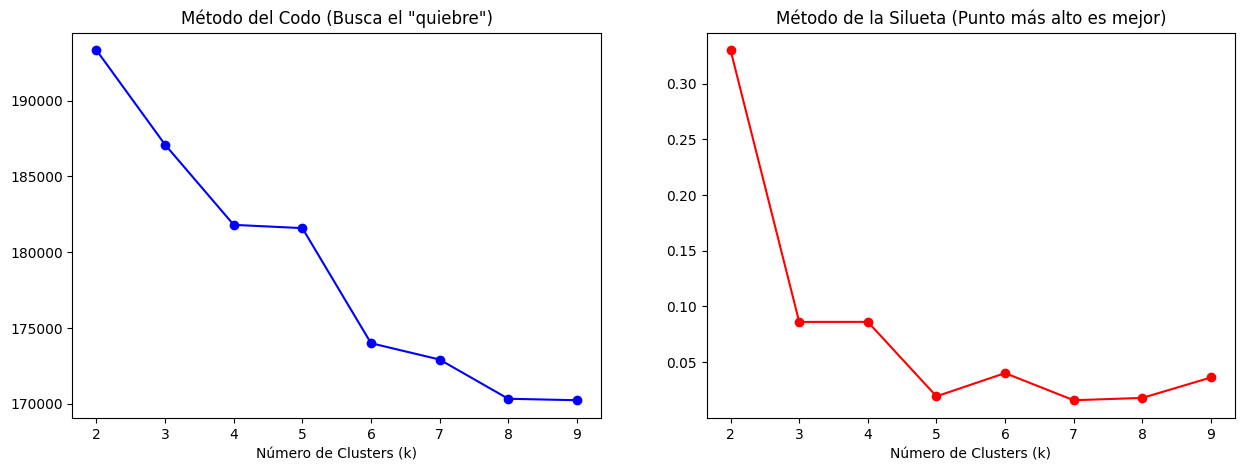

In [3]:
# ESCALAMIENTO
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# DETERMINACIÓN DE CLUSTERS
wcss = []
s_scores = []
k_range = range(2, min(10, len(df_encoded))) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    s_scores.append(silhouette_score(X_scaled, labels))

# Gráficos de validación
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(k_range, wcss, marker='o', color='blue')
ax[0].set_title('Método del Codo (Busca el "quiebre")')
ax[0].set_xlabel('Número de Clusters (k)')

ax[1].plot(k_range, s_scores, marker='o', color='red')
ax[1].set_title('Método de la Silueta (Punto más alto es mejor)')
ax[1].set_xlabel('Número de Clusters (k)')
plt.show()

In [4]:
# Supongamos que el gráfico indicó que k=3 es el ideal
k_final = 5 
kmeans_final = KMeans(n_clusters=k_final, init='k-means++', random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

print("Distribución por Cluster:")
print(df['Cluster'].value_counts())

Distribución por Cluster:
Cluster
4    351
3    133
1     85
2     18
0      4
Name: count, dtype: int64


--- PERFIL POR CLUSTER ---


,Cluster,Nota final,Sede,Estado
0,0,67.500000,Santiago,Enviada
1,1,47.137255,Santiago,Enviada
2,2,0.000000,Santiago,En creación
3,3,52.255639,Santiago,Enviada
4,4,51.614435,Santiago,Enviada


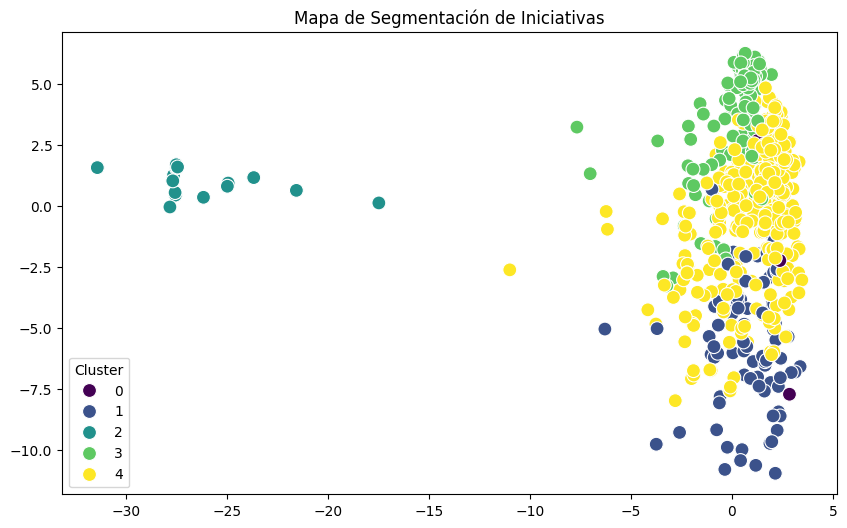

In [5]:
perfil = df.groupby('Cluster').agg({
    'Nota final': 'mean',
    'Sede': lambda x: x.mode()[0] if not x.mode().empty else "N/A",
    'Estado': lambda x: x.mode()[0] if not x.mode().empty else "N/A"
}).reset_index()

print("--- PERFIL POR CLUSTER ---")
display(perfil)

# Visualización PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('Mapa de Segmentación de Iniciativas')
plt.show()